# Task 1.1

(441, 321, 215)


Text(0.5, 1.0, 'mid axial spine vertebrae')

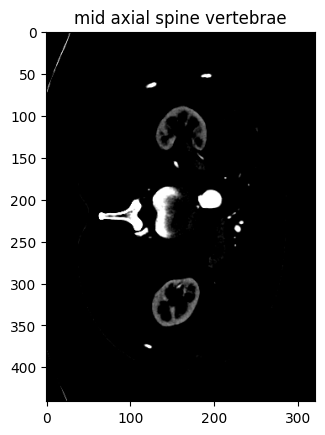

In [1]:
# import nibabel as nib
import matplotlib.pyplot as plt
import nrrd 
import SimpleITK as sitk
import numpy as np
# # Load the NRRD file using nrrd
NRRD_PATH = "/apps/local/shared/HC701/assessment/assignment_2/task_1/CTA-Abdomen.nrrd"
img_data = nrrd.read(NRRD_PATH)[0]
print(img_data.shape)
# Find the optimal intensity window for the spine vertebrae
min_intensity = 100
max_intensity = 300 # 250, 300 make sense

clipped_img = img_data.clip(min_intensity,max_intensity)

# Generate three images
img1 = clipped_img[:, :, img_data.shape[-1]//2]
img2 = clipped_img[:, img_data.shape[-2]//2 , :]
img3 = clipped_img[img_data.shape[0]//2, : , :]

plt.imshow(img1, cmap='gray')
plt.title('mid axial spine vertebrae')


Text(0.5, 1.0, 'coronal spine vertebrae')

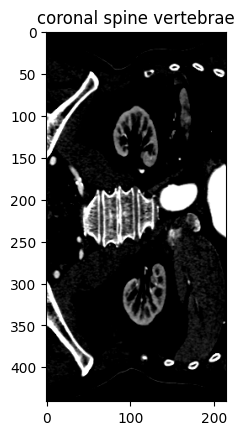

In [2]:
plt.imshow(img2, cmap='gray')
plt.title('coronal spine vertebrae')

Text(0.5, 1.0, 'sagittal spine vertebrae')

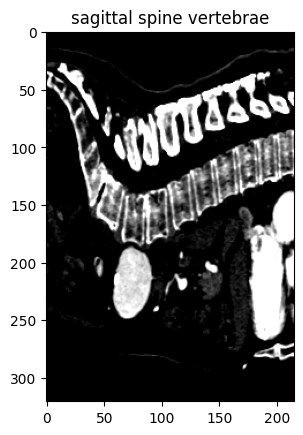

In [3]:
plt.imshow(img3, cmap='gray')
plt.title('sagittal spine vertebrae')

# Task 1.2

In [2]:
import SimpleITK as sitk
import numpy as np


# use watershed algorithm to get segmentation
min_intensity = 100
max_intensity = 300 # 250, 300 make sense

clipped_img = img_data.clip(min_intensity,max_intensity)
org_img = clipped_img[img_data.shape[0]//2, : , :]
img4 = clipped_img[img_data.shape[0]//2, : , :]
image = sitk.GetImageFromArray(img4)

# Preprocessing to enhance the image
# Here, we apply a Gaussian smoothing filter and a histogram equalization filter
image_smooth = sitk.SmoothingRecursiveGaussian(image, 1.0)
image_eq = sitk.AdaptiveHistogramEqualization(image_smooth)

# Thresholding to separate the vertebrae from the background
threshold_filter = sitk.BinaryThresholdImageFilter()
threshold_filter.SetLowerThreshold(200) # Adjust the threshold value as needed
threshold_filter.SetUpperThreshold(2000) # Adjust the threshold value as needed
threshold_filter.SetInsideValue(1)
threshold_filter.SetOutsideValue(0)
image_threshold = threshold_filter.Execute(image_eq)

# Morphological operations to remove small objects and fill holes
closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
closing_filter.SetKernelRadius(2)
image_closing = closing_filter.Execute(image_threshold)

opening_filter = sitk.BinaryMorphologicalOpeningImageFilter()
opening_filter.SetKernelRadius(2)
image_opening = opening_filter.Execute(image_closing)

# Connected component analysis to separate individual vertebrae
cc_filter = sitk.ConnectedComponentImageFilter()
image_cc = cc_filter.Execute(image_opening)

# Extract the largest connected component (which should be the vertebrae)
label_shape_stats = sitk.LabelShapeStatisticsImageFilter()
label_shape_stats.Execute(image_cc)
labels = label_shape_stats.GetLabels()
largest_label = None
largest_size = 0
for label in labels:
    size = label_shape_stats.GetNumberOfPixels(label)
    if size > largest_size:
        largest_label = label
        largest_size = size
image_largest_cc = sitk.RelabelComponent(image_cc, largest_label)

# Get the segmentation as a numpy array for further processing or visualization
segmentation = sitk.GetArrayFromImage(image_largest_cc)


array([ 0,  4,  5,  7,  8,  9, 11, 13, 14, 15, 16], dtype=uint32)

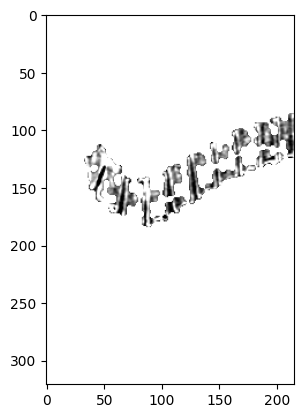

In [3]:
# get spine segmentation and show it on spine image
segmentation[segmentation>16] = 0
segmentation[segmentation<4] = 0
segmentation[:80,:] = 0
img4[segmentation>16] = 300
img4[segmentation<4] = 300
img4[:80,:] = 300
plt.imshow(img4, cmap='gray')
np.unique(segmentation)

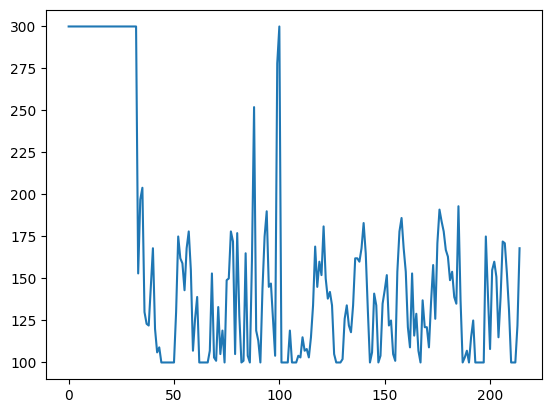

In [4]:
# find local min pixel as split 
x, y = [],[]
for j in range(img4.shape[1]):
    x.append(j)
    y.append(np.min(img4[:,j]))
plt.plot(x,y)
        

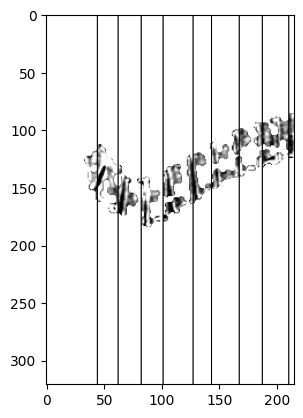

In [5]:
win = 20
split_points=[]
for j in range(int(img4.shape[1]/win )+1):
    min = np.min(y[j*win:(j+1)*win])
    if min < 120:
        idx = y[j*win:(j+1)*win].index(min)
        split_points.append(j*win+idx)
split_img = img4.copy()
split_img[:,split_points] = 100
plt.imshow(split_img, cmap='gray')


In [89]:
# get corresponding box
import pdb
boxes = []
old_max_idx = 0
old_min_idx = 0
old_j = 0
for j in split_points:
    if old_max_idx == 0:
        old_max_idx = np.max(np.where(img4[:,j]<300))
        old_min_idx = np.min(np.where(img4[:,j]<300))
        old_j = j
    else:
        max_idx = np.max(np.where(img4[:,j]<300))
        min_idx = np.min(np.where(img4[:,j]<300))
        
        l = [old_j,np.min([old_min_idx,min_idx])]
        r = [j,np.max([old_max_idx,max_idx])]
        boxes.append(l+r)
        old_max_idx = max_idx
        old_min_idx = min_idx
        old_j = j  
boxes

[[44, 114, 62, 172],
 [62, 136, 82, 172],
 [82, 137, 101, 178],
 [101, 121, 127, 178],
 [127, 111, 143, 164],
 [143, 99, 167, 151],
 [167, 94, 187, 140],
 [187, 87, 210, 129]]

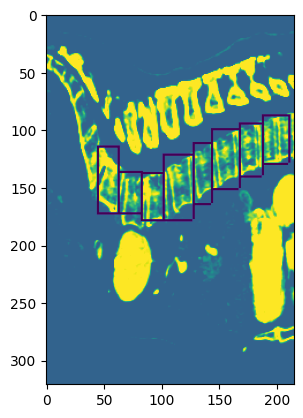

In [96]:
# show boxes
import SimpleITK as sitk
import numpy as np

# Convert the image to a numpy array for drawing
image_array = img3

# Define the box points as (x1, y1, x2, y2) where (x1,y1) is the top left corner and (x2,y2) is the bottom right corner of the box
mask_img = np.zeros(img3.shape)

# Draw boxes on the image array
for box in boxes:
    x1, y1, x2, y2 = box
    image_array[y1:y2, x1:x1+2] = 0
    image_array[y1:y2, x2:x2+2] = 0
    image_array[y1:y1+2, x1:x2] = 0
    image_array[y2:y2+2, x1:x2] = 0
    mask_img[y1:y2,x1:x2] = img3[y1:y2,x1:x2]

# Convert the image array back to a SimpleITK image
plt.imshow(image_array)


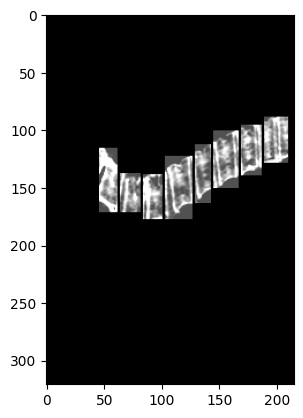

In [97]:
# only keep box vertebrae
plt.imshow(mask_img,cmap='gray')

In [7]:
# 3D 
import SimpleITK as sitk
import numpy as np
def Locate_vertebra(img_data, splice_num):
# use watershed algorithm to get segmentation
    min_intensity = 100
    max_intensity = 300 # 250, 300 make sense

    clipped_img = img_data.clip(min_intensity,max_intensity)
    img4 = clipped_img[splice_num, : , :]
    org_img = img4.copy()
    image = sitk.GetImageFromArray(img4)

    # Preprocessing to enhance the image
    # Here, we apply a Gaussian smoothing filter and a histogram equalization filter
    image_smooth = sitk.SmoothingRecursiveGaussian(image, 1.0)
    image_eq = sitk.AdaptiveHistogramEqualization(image_smooth)

    # Thresholding to separate the vertebrae from the background
    threshold_filter = sitk.BinaryThresholdImageFilter()
    threshold_filter.SetLowerThreshold(200) # Adjust the threshold value as needed
    threshold_filter.SetUpperThreshold(2000) # Adjust the threshold value as needed
    threshold_filter.SetInsideValue(1)
    threshold_filter.SetOutsideValue(0)
    image_threshold = threshold_filter.Execute(image_eq)

    # Morphological operations to remove small objects and fill holes
    closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
    closing_filter.SetKernelRadius(2)
    image_closing = closing_filter.Execute(image_threshold)

    opening_filter = sitk.BinaryMorphologicalOpeningImageFilter()
    opening_filter.SetKernelRadius(2)
    image_opening = opening_filter.Execute(image_closing)

    # Connected component analysis to separate individual vertebrae
    cc_filter = sitk.ConnectedComponentImageFilter()
    image_cc = cc_filter.Execute(image_opening)

    # Extract the largest connected component (which should be the vertebrae)
    label_shape_stats = sitk.LabelShapeStatisticsImageFilter()
    label_shape_stats.Execute(image_cc)
    labels = label_shape_stats.GetLabels()
    largest_label = None
    largest_size = 0
    for label in labels:
        size = label_shape_stats.GetNumberOfPixels(label)
        if size > largest_size:
            largest_label = label
            largest_size = size
    image_largest_cc = sitk.RelabelComponent(image_cc, largest_label)

    # Get the segmentation as a numpy array for further processing or visualization
    segmentation = sitk.GetArrayFromImage(image_largest_cc)
    # limit range
    segmentation[segmentation>16] = 0
    segmentation[segmentation<4] = 0
    segmentation[:80,:] = 0
    img4[segmentation>16] = 300
    img4[segmentation<4] = 300
    img4[:80,:] = 300
    # find local min
    x, y = [],[]
    for j in range(img4.shape[1]):
        x.append(j)
        y.append(np.min(img4[:,j]))
    win = 20
    split_points=[]
    for j in range(int(img4.shape[1]/win )+1):
        min = np.min(y[j*win:(j+1)*win])
        if min < 120:
            idx = y[j*win:(j+1)*win].index(min)
            split_points.append(j*win+idx)
    split_img = img4.copy()
    split_img[:,split_points] = 100
    
    boxes = []
    old_max_idx = 0
    old_min_idx = 0
    old_j = 0
    for j in split_points:
        if old_max_idx == 0:
            old_max_idx = np.max(np.where(img4[:,j]<300))
            old_min_idx = np.min(np.where(img4[:,j]<300))
            old_j = j
        else:
            max_idx = np.max(np.where(img4[:,j]<300))
            min_idx = np.min(np.where(img4[:,j]<300))
            
            l = [old_j,np.min([old_min_idx,min_idx])]
            r = [j,np.max([old_max_idx,max_idx])]
            boxes.append(l+r)
            old_max_idx = max_idx
            old_min_idx = min_idx
            old_j = j  
            
    image_array = org_img

    mask_img = np.zeros(org_img.shape)

    # Draw boxes on the image array
    for box in boxes:
        x1, y1, x2, y2 = box
        image_array[y1:y2, x1:x1+2] = 0
        image_array[y1:y2, x2:x2+2] = 0
        image_array[y1:y1+2, x1:x2] = 0
        image_array[y2:y2+2, x1:x2] = 0
        mask_img[y1:y2,x1:x2] = org_img[y1:y2,x1:x2]

    # Convert the image array back to a SimpleITK image
    return image_array
        
        

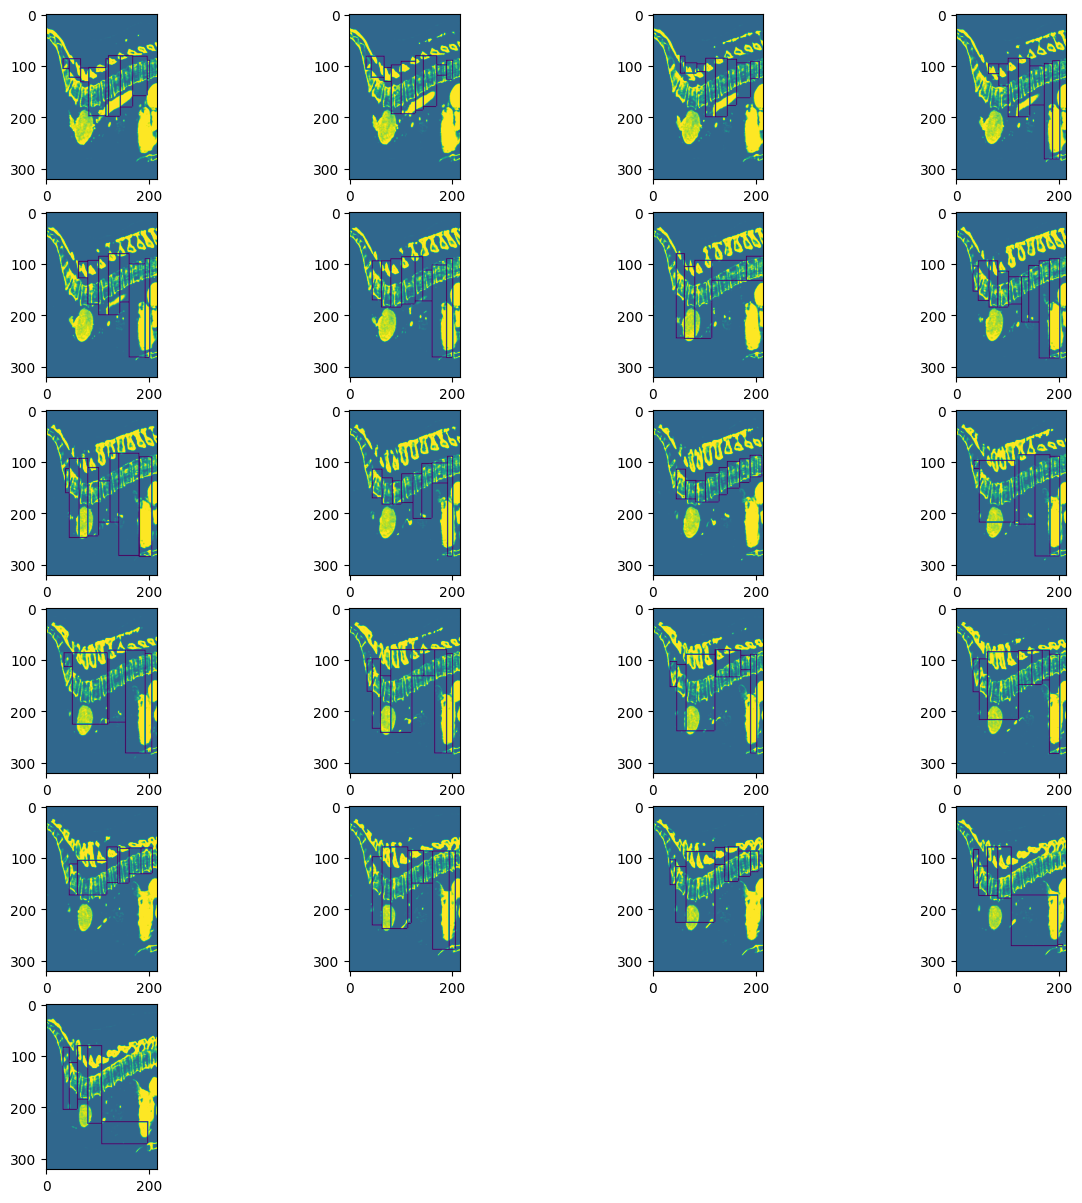

In [9]:
mid = img_data.shape[0]//2
w = 20
h = 20
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 6

for i in range(mid-10,mid+11):
    ret = Locate_vertebra(img_data,i)
    fig.add_subplot(rows, columns, i-mid+11)
    plt.imshow(ret)
plt.show()

# Task 2.1

In [26]:
import os
import pandas as pd

DATA_PATH = '/home/ning.sun/Documents/HC701/assignment/ass2/TBX11K/imgs'
CSV_PATH = 'task21.csv'
# load data
health_data = os.listdir(os.path.join(DATA_PATH,'health'))
tb_data = os.listdir(os.path.join(DATA_PATH,'tb'))
# sort
health_data.sort()
tb_data.sort()
# prepare for csv
len_health_data = len(health_data)
len_tb_data = len(tb_data)
num_test_health = int(0.2 * len_health_data)
num_test_tb = int(0.2 * len_tb_data)
labels = ['health'] * len_health_data + ['tb'] * len_tb_data
types = ['test'] * num_test_health + ['train'] * (len_health_data - num_test_health) + ['test'] * num_test_tb + ['train']* (len_tb_data - num_test_tb)
datas = health_data + tb_data
# save
dataframe = pd.DataFrame({'filename':datas,'types':types,'labels':labels})
dataframe.to_csv(CSV_PATH, index=False)

        


# Task 2.2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

In [3]:

# load data
DATA_PATH = '/home/ning.sun/Documents/HC701/assignment/ass2/TBX11K/imgs'
CSV_PATH = 'task21.csv'

dataframe = pd.read_csv(CSV_PATH)
test_data = dataframe[dataframe['types']=='test']['filename'].tolist()
test_labels = dataframe[dataframe['types']=='test']['labels'].tolist()
train_data = dataframe[dataframe['types']=='train']['filename'].tolist()
train_labels = dataframe[dataframe['types']=='train']['labels'].tolist()
# tb 1 health 0
# to tensor
train_labels = torch.tensor([1 if label == 'tb' else 0 for label in train_labels])
test_labels = torch.tensor([1 if label == 'tb' else 0 for label in test_labels])



In [4]:
# wandb 
wandb.init(project="hc_assign2", config={"learning_rate": 0.01})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sunning. Use `wandb login --relogin` to force relogin


In [5]:
# model
import torch
import torch.nn as nn
import torch.optim as optim
import pdb

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.functional.relu(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet50, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def train(model, train_loader, optimizer, criterion, epochs,device):
    model.train()
    for epoch in range(epochs):
        loss_epoch = 0.0
        correct = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss_epoch += loss
        wandb.log({'train_loss':loss_epoch.item(),'epoch':epoch})
        wandb.log({'train_accuracy':correct/len(train_loader.dataset),'epoch':epoch})
        print(f'epoch{epoch}: loss {loss_epoch.item()}, accuracy:{correct/len(train_loader.dataset)}')
            


def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'test_acc: {100. * correct / len(test_loader.dataset)}')


In [6]:
# data augmentation
class MyDataset(Dataset):
    def __init__(self,data,label,transform) -> None:
        super().__init__()
        self.data = data
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.label[index]
        # load image
        if x.startswith('h'):
            img = Image.open(os.path.join(DATA_PATH,'health',x))
        elif x.startswith('t'):
            img = Image.open(os.path.join(DATA_PATH,'tb',x))
        # transform
        if self.transform:
            img = self.transform(img)
        return [img, y]

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = MyDataset(train_data,train_labels,transform=transform)
train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
test_dataset = MyDataset(test_data,test_labels,transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset,batch_size=4)

In [7]:
# model: ResNet50
model1 = ResNet50(BasicBlock, [3, 4, 6, 3])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(),lr=0.001, momentum=0.9)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1.to(device)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [8]:
# train
train(model1,train_loader,optimizer,criterion,epochs=20,device=device)
# test
test(model1, test_loader, criterion, device)  

wandb.finish()       